# Simple laminated plate example

Text(0, 0.5, 'z (mm)')

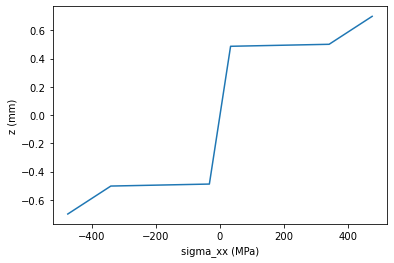

In [7]:
from fedoo import *
import numpy as np
from matplotlib import pylab as plt
import os
Util.ProblemDimension("3D")
E = 1e5 

L = 100
h = 20
thickness = 1
F = -100

geomElementType = 'quad4' #choose among 'tri3', 'tri6', 'quad4', 'quad9'
plateElementType = 'p'+geomElementType #plate interpolation. Same as geom interpolation in local element coordinate (change of basis)
reduced_integration = False #if true, use reduce integration for shear 
saveResults = True

mat1 = ConstitutiveLaw.ElasticIsotrop(1e5, 0.3, ID = 'Mat1') #E1 = 1e5, nu1 = 0.3
mat2 = ConstitutiveLaw.ElasticIsotrop(1e4, 0.3, ID = 'Mat2') #E2 = 1e5, nu2 = 0.3

#3 layers with thickness 0.2, 1 and 0.2 (sandwich pannel)
ConstitutiveLaw.ShellLaminate(['Mat1', 'Mat2', 'Mat1'], [0.2,1,0.2], ID = 'PlateSection') 

mesh = Mesh.RectangleMesh(201,21,0,L,-h/2,h/2, geomElementType, ID='plate', ndim = 3)

nodes_left = mesh.GetSetOfNodes('left')
nodes_right = mesh.GetSetOfNodes('right')

node_right_center = nodes_right[(mesh.GetNodeCoordinates()[nodes_right,1]**2).argmin()]


if reduced_integration == False:
    WeakForm.Plate("PlateSection", ID = "WFplate") #by default k=0 i.e. no shear effect
    Assembly.Create("WFplate", "plate", plateElementType, ID="plate")    
else:    
    WeakForm.Plate_RI("PlateSection", ID = "WFplate_RI") #by default k=0 i.e. no shear effect
    Assembly.Create("WFplate_RI", "plate", plateElementType, ID="plate_RI", nb_pg = 1)  #set nb_pg = 1
    
    WeakForm.Plate_FI("PlateSection", ID = "WFplate_FI") #by default k=0 i.e. no shear effect
    Assembly.Create("WFplate_FI", "plate", plateElementType, ID="plate_FI") 
    
    Assembly.Sum("plate_RI", "plate_FI", ID = "plate", assembly_output = 'plate_FI') 
    #assembly_ouput = assembly used to output data

Problem.Static("plate")
Problem.SetSolver('cg')

#create a 'result' folder and set the desired ouputs
if not(os.path.isdir('results')): os.mkdir('results')
Problem.AddOutput('results/simplePlate', 'plate', ['disp','rot', 'stress', 'strain'], output_type='Node', file_format ='vtk', position = -1)    


Problem.BoundaryCondition('Dirichlet','DispX',0,nodes_left)
Problem.BoundaryCondition('Dirichlet','DispY',0,nodes_left)
Problem.BoundaryCondition('Dirichlet','DispZ',0,nodes_left)
Problem.BoundaryCondition('Dirichlet','RotX',0,nodes_left)
Problem.BoundaryCondition('Dirichlet','RotY',0,nodes_left)
Problem.BoundaryCondition('Dirichlet','RotZ',0,nodes_left)

Problem.BoundaryCondition('Neumann','DispZ',F,node_right_center)

Problem.ApplyBoundaryCondition()
Problem.Solve()

if saveResults == True: 
    Problem.SaveResults() #save in vtk

z, StressDistribution = ConstitutiveLaw.GetAll()['PlateSection'].GetStressDistribution(200)
plt.plot(StressDistribution[0], z)

plt.xlabel('sigma_xx (MPa)')
plt.ylabel('z (mm)')
